In [166]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *

In [167]:
# use custom function to get the corpus df, label dfs, and validation dfs
corpus_df, val_corpus_df, emotion_df, val_emotion_df, valence_df, val_valence_df = get_labeled_dfs()


In [168]:
# using custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)


In [169]:
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,two hussein ally hang iraqi official say
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [170]:
valence_df.head()

,valence,label
0,32,1
1,-48,0
2,26,1
3,40,1
4,-6,2


In [171]:
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,label
0,0,0,15,38,9,11,joy,3
1,24,26,16,13,38,5,sadness,4
2,0,0,0,17,0,4,joy,3
3,0,0,0,46,0,31,joy,3
4,1,0,23,8,11,8,fear,2


## Valence labels

In [172]:
X = corpus_df['text']
y = valence_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)


In [173]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape


(750, 2004)

In [174]:
smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape


(1032, 2004)

In [175]:
svm_classifier = SVC(class_weight='balanced', random_state=1)

svm_classifier.fit(X_res, y_res)
svm_train_preds = svm_classifier.predict(X_res)
svm_test_preds = svm_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM
Training Accuracy: 0.7151162790697675
Training F1: 0.6632630827170752
Testing Accuracy: 0.624
Testing F1: 0.5767389162561576




Text(69.0, 0.5, 'Predicted')

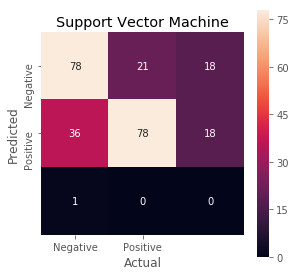

In [176]:
svm_train_acc = accuracy_score(y_res, svm_train_preds)
svm_test_acc = accuracy_score(y_test, svm_test_preds)
svm_train_f1 = f1_score(y_res, svm_train_preds, average='weighted')
svm_test_f1 = f1_score(y_test, svm_test_preds, average='weighted')

print("SVM")
print("Training Accuracy:", svm_train_acc)
print("Training F1:", svm_train_f1)
print("Testing Accuracy:", svm_test_acc)
print("Testing F1:", svm_test_f1)
print("\n")
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
cm = confusion_matrix(y_test, svm_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive', 'Neutral'], xticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Support Vector Machine')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [177]:
df = pd.DataFrame({"true": y_test, "predicted":svm_test_preds})
len(df.loc[(df.true==1) & (df.predicted==2)])

0

# Gridsearch

In [178]:
## Gridsearch RBF

smt = SMOTE(random_state=1)
classifier = SVC(kernel="rbf")


pipe = Pipeline([('smote', smt), ('classifier', classifier)])

param_grid = {
    
    'classifier__C': [.001, .1, 1, 10, 100, 1000, 10000, 100000],

    'classifier__gamma': [0.001, .01, 1, 10],

}

gs_val_rbf = GridSearchCV(pipe, param_grid, cv = 5, scoring='balanced_accuracy', n_jobs=3)
gs_val_rbf .fit(tf_idf_X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=1, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('classifier',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_fun...
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=

In [179]:
gs_val_rbf.best_estimator_


Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=1, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('classifier',
                 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=1,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [180]:
gs_val_rbf .best_score_


0.5056880141181325

In [181]:
## Gridsearch Polynomial
smt = SMOTE(random_state=1)
classifier = SVC(kernel="poly")


pipe = Pipeline([('smote', smt), ('classifier', classifier)])

param_grid = {
    
    'classifier__C': [.001, .1, 1, 10, 100, 1000, 10000, 100000],
    'classifier__degree': [3, 4],
    'classifier__coef0': [0.1, 0.5, 1, 1.5, 2],
    'classifier__gamma': [0.1, .05, 1],

}

gs_val_poly = GridSearchCV(pipe, param_grid, cv = 5, scoring='balanced_accuracy', n_jobs=3)
gs_val_poly.fit(tf_idf_X_train, y_train)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=1, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('classifier',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_fun...
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=Fals

In [182]:
gs_val_poly.best_estimator_


Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=1, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('classifier',
                 SVC(C=1, cache_size=200, class_weight=None, coef0=1,
                     decision_function_shape='ovr', degree=4, gamma=1,
                     kernel='poly', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [183]:
gs_val_poly.best_score_


0.5145155878204731

In [187]:
gs_val_poly.fit(X_res, y_res)
svm_train_preds = gs_val_poly.predict(X_res)
svm_test_preds = gs_val_poly.predict(tf_idf_X_test)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVM
Training Accuracy: 1.0
Training F1: 1.0
Testing Accuracy: 0.588
Testing F1: 0.5604709270927093




Text(69.0, 0.5, 'Predicted')

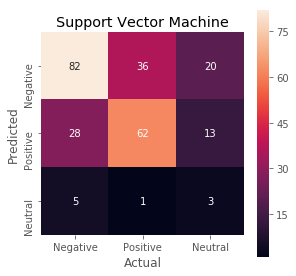

In [188]:
svm_train_acc = accuracy_score(y_res, svm_train_preds)
svm_test_acc = accuracy_score(y_test, svm_test_preds)
svm_train_f1 = f1_score(y_res, svm_train_preds, average='weighted')
svm_test_f1 = f1_score(y_test, svm_test_preds, average='weighted')

print("SVM")
print("Training Accuracy:", svm_train_acc)
print("Training F1:", svm_train_f1)
print("Testing Accuracy:", svm_test_acc)
print("Testing F1:", svm_test_f1)
print("\n")
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
cm = confusion_matrix(y_test, svm_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive', 'Neutral'], xticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Support Vector Machine')
plt.xlabel('Actual')
plt.ylabel('Predicted')


In [184]:
# Gridsearch Sigmoid

smt = SMOTE(random_state=1)
classifier = SVC(kernel="sigmoid")


pipe = Pipeline([('smote', smt), ('classifier', classifier)])

param_grid = {
    
    'classifier__C': [.001, .1, 1, 10, 100, 1000, 10000],
    'classifier__coef0': [0.001, 0.01, .1, 1],
    'classifier__gamma': [0.01, 0.1, 1, 5, 10],

}

gs_val_sig = GridSearchCV(pipe, param_grid, cv = 5, scoring='balanced_accuracy', n_jobs=3)
gs_val_sig.fit(tf_idf_X_train, y_train)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=1, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('classifier',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_fun...
                                            kernel='sigmoid', max_iter=-1,
                                            probability=False,
        

In [185]:
gs_val_sig.best_estimator_


Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=1, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('classifier',
                 SVC(C=10, cache_size=200, class_weight=None, coef0=1,
                     decision_function_shape='ovr', degree=3, gamma=0.1,
                     kernel='sigmoid', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [186]:
gs_val_sig.best_score_


0.5058933832586354

## Emotion categories

In [153]:
X = corpus_df['text']
y = emotion_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)


In [154]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape


(750, 2005)

In [155]:
smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape


(1632, 2005)

In [156]:
svm_classifier = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.001,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False)

svm_classifier.fit(X_res , y_res)
svm_train_preds = svm_classifier.predict(X_res)
svm_test_preds = svm_classifier.predict(tf_idf_X_test)

SVM
Training Accuracy: 0.9975490196078431
Training F1: 0.9975490072073595
Testing Accuracy: 0.536
Testing F1: 0.5329597726759017




Text(55.90909090909091, 0.5, 'Predicted')

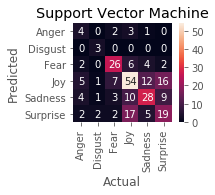

In [157]:
svm_train_acc = accuracy_score(y_res, svm_train_preds)
svm_test_acc = accuracy_score(y_test, svm_test_preds)
svm_train_f1 = f1_score(y_res, svm_train_preds, average='weighted')
svm_test_f1 = f1_score(y_test, svm_test_preds, average='weighted')

print("SVM")
print("Training Accuracy:", svm_train_acc)
print("Training F1:", svm_train_f1)
print("Testing Accuracy:", svm_test_acc)
print("Testing F1:", svm_test_f1)
print("\n")

cm = confusion_matrix(y_test, svm_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'], xticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])
plt.title('Support Vector Machine')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [146]:
df = pd.DataFrame({"true": y_test, "predicted":svm_test_preds})
len(df.loc[(df.true==2) & (df.predicted==0)])

5

## Gridsearch

In [150]:
smt = SMOTE(random_state=1)
classifier = SVC(kernel="rbf")


pipe = Pipeline([('smote', smt), ('classifier', classifier)])

param_grid = {
    
    'classifier__C': [.001, .1, 1, 10, 100, 1000, 10000, 100000],

    'classifier__gamma': [0.001, .01, 1, 10],

}

gs = GridSearchCV(pipe, param_grid, cv = 5, scoring='balanced_accuracy', n_jobs=3)
gs.fit(tf_idf_X_train, y_train)

1e-1, 1, 1e1

(0.1, 1, 10.0)

In [158]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=1, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('classifier',
                 SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.001,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [159]:
gs.best_score_

0.34120434288265833

In [160]:
svm_train_preds = gs.predict(X_res)
svm_test_preds = gs.predict(tf_idf_X_test)

SVM
Training Accuracy: 0.9975490196078431
Training F1: 0.9963233803260378
Testing Accuracy: 0.536
Testing F1: 0.5327085168117426




Text(55.90909090909091, 0.5, 'Predicted')

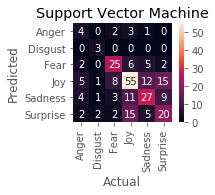

In [161]:
vm_train_acc = accuracy_score(y_res, svm_train_preds)
svm_test_acc = accuracy_score(y_test, svm_test_preds)
svm_train_f1 = f1_score(y_res, svm_train_preds, average='weighted')
svm_test_f1 = f1_score(y_test, svm_test_preds, average='weighted')

print("SVM")
print("Training Accuracy:", svm_train_acc)
print("Training F1:", svm_train_f1)
print("Testing Accuracy:", svm_test_acc)
print("Testing F1:", svm_test_f1)
print("\n")

cm = confusion_matrix(y_test, svm_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'], xticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])
plt.title('Support Vector Machine')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [130]:
smt = SMOTE(random_state=1)
classifier = SVC(kernel="")


pipe = Pipeline([('smote', smt), ('classifier', classifier)])

param_grid = {
    
    'classifier__C': [.001, .1, 1, 10, 100, 1000, 10000, 100000],
    'classifier__degree': [3, 4],
    'classifier__coef0': [0.1, 0.5, 1, 1.5, 2],
    'classifier__gamma': [0.1, .05, 1],

}

gs = GridSearchCV(pipe, param_grid, cv = 5, scoring='balanced_accuracy', n_jobs=3)
gs.fit(tf_idf_X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=1, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('classifier',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_fun...
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=Fals

In [131]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=1, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('classifier',
                 SVC(C=1, cache_size=200, class_weight=None, coef0=0.5,
                     decision_function_shape='ovr', degree=4, gamma=1,
                     kernel='poly', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [132]:
gs.best_score_

0.349804873448601

In [141]:
smt = SMOTE(random_state=1)
classifier = SVC(kernel="sigmoid")


pipe = Pipeline([('smote', smt), ('classifier', classifier)])

param_grid = {
    
    'classifier__C': [.001, .1, 1, 10, 100, 1000, 10000],
    'classifier__coef0': [0.001, 0.01, .1, 1],
    'classifier__gamma': [0.01, 0.1, 1, 5, 10],

}

gs = GridSearchCV(pipe, param_grid, cv = 5, scoring='balanced_accuracy', n_jobs=3)
gs.fit(tf_idf_X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=1, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('classifier',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_fun...
                                            kernel='sigmoid', max_iter=-1,
                                            probability=False,
        

In [142]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=1, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('classifier',
                 SVC(C=10, cache_size=200, class_weight=None, coef0=1,
                     decision_function_shape='ovr', degree=3, gamma=1,
                     kernel='sigmoid', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [143]:
gs.best_score_

0.3519488119805324